Carlos Octavio Ordaz Bernal

158525

Visión por Computadora

24 de marzo de 2019

                                Tarea 4: SIFT - BoW - SVM

In [105]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from random import randint
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
clases = list(glob.glob("101_ObjectCategories/*/"))
dic = {}
for i in range(len(clases)):
    nombreClase = clases[i].split('\\')[1]
    directorio = "101_ObjectCategories/"+nombreClase+"/*.jpg"
    archivos = list(glob.iglob(directorio, recursive=True))
    listaImagenes = []
    for j in range(len(archivos)):
        img = io.imread(archivos[j])
        listaImagenes.append(img)
    dic[nombreClase] = listaImagenes

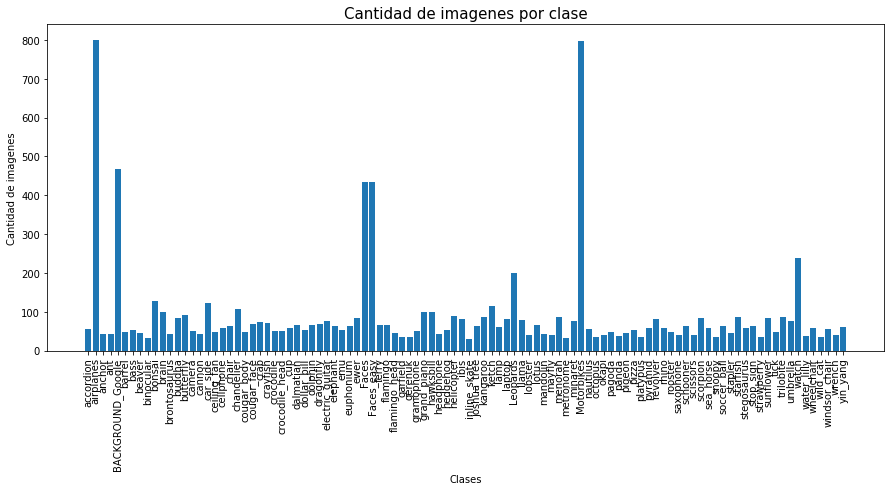

In [3]:
def graficaElementos(listaClases, listaAux):
    listaCuenta = []
    for i in range(len(listaClases)):
        valor = len(listaAux[i])
        listaCuenta.append(valor)
    plt.figure(figsize=(15, 6))
    plt.bar(listaClases, listaCuenta)
    plt.title("Cantidad de imagenes por clase",size=15)
    plt.xlabel("Clases")
    plt.xticks(rotation=90)
    plt.ylabel("Cantidad de imagenes")   
    
listaClases = list(dic.keys())
listaAux = list(dic.values())
graficaElementos(listaClases, listaAux)

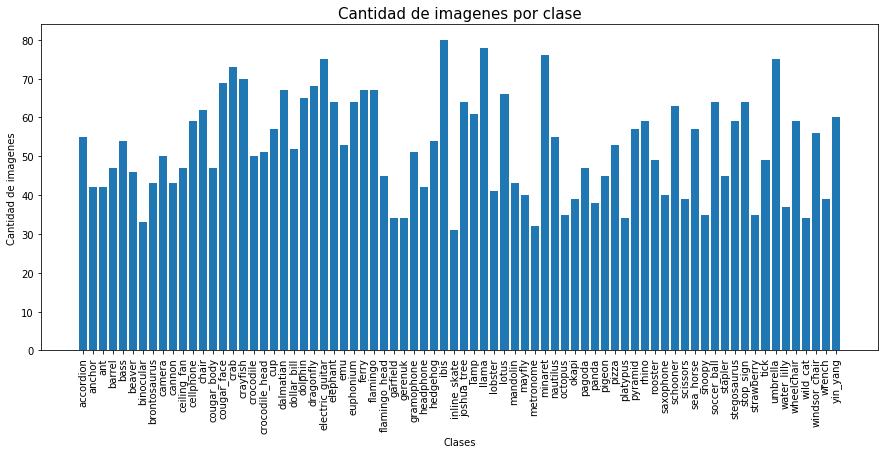

In [4]:
listaClases = list(dic.keys())
listaImagenes = list(dic.values())
listaCuenta = []
for i in range(len(listaClases)):
    valor = len(listaImagenes[i])
    if valor > 80:
        del dic[listaClases[i]]
listaClases = list(dic.keys())
listaAux = list(dic.values())
graficaElementos(listaClases, listaAux)

In [5]:
dicTrain = {}
dicValidation = {}
listaClases = list(dic.keys())
listaImagenes = list(dic.values())
for i in range(len(listaClases)):
    x_train, x_val = train_test_split(listaImagenes[i], test_size = 0.2, train_size = 0.8, shuffle = True)
    dicTrain[listaClases[i]] = x_train
    dicValidation[listaClases[i]] = x_val

In [6]:
listaClases = list(dicTrain.keys())
listaAux = []
listaTrain = list(dicTrain.values())
etiquetasTrain = []
imgTrain = []
for i in range(len(listaClases)):
    listaAux = listaTrain[i]
    for j in range(len(listaAux)):
        etiquetasTrain.append(i)
        imgTrain.append(listaAux[j])
listaAux = []
listaVal = list(dicValidation.values())
etiquetasVal = []
imgVal  = []
for k in range(len(listaClases)):
    listaAux = listaVal[k]
    for l in range(len(listaAux)):
        etiquetasVal.append(k)
        imgVal.append(listaAux[l])

4.632993


C:\Users\super\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\super\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


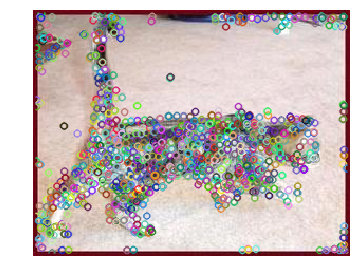

In [46]:
def compute_SIFT(imagen):
    #gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    gray = imagen
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)
    img = cv2.drawKeypoints(gray, kp, imagen)
    desNorm = preprocessing.normalize(des) 
    return img, desNorm

valor = randint(0, len(imgTrain) - 1)
image, des = compute_SIFT(imgTrain[valor])
plt.figure()
io.imshow(image)
plt.axis('off')
print(np.sum(des[0,:])) # No se porque no me da la suma igual a uno.

In [8]:
SIFT_train = np.zeros((20000, 128))
i = 0
while i < 20000:
    valor = randint(0, len(imgTrain)-1)
    try:
        image, des = compute_SIFT(imgTrain[valor])
    except:
        continue
    for j in range(np.shape(des)[0]):
        if i >= 20000:
            break
        SIFT_train[i,:] = des[j,:]
        i = i + 1
    
print(np.shape(SIFT_train))

(20000, 128)


In [9]:
kmeans = KMeans(n_clusters = 200, random_state = 0).fit(SIFT_train)
kmeans.labels_

array([106, 134, 125, ...,  87,  39,  61])

Text(0,0.5,'Frecuencia')

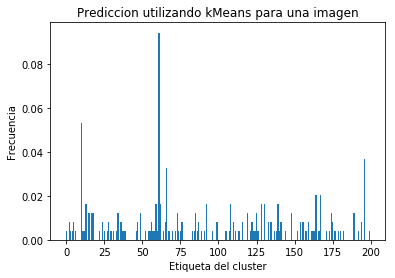

In [21]:
def get_bow(imagen):
    imgSIFT, descriptores = compute_SIFT(imagen)
    etiquetas = []
    for i in range(np.shape(descriptores)[0]):
        cercano = kmeans.predict([descriptores[i]])
        for j in range(len(cercano)):
            etiquetas.append(cercano[j])
    distribucion = np.zeros((1,200))
    for k in range(len(etiquetas)):
        distribucion[0,etiquetas[k]] = distribucion[0,etiquetas[k]] + 1
    return distribucion[0]/len(etiquetas)

valor = randint(0, len(imgTrain) - 1)
distribucion = get_bow(imgTrain[valor])
plt.figure()
plt.bar(range(200), distribucion)
plt.title('Prediccion utilizando kMeans para una imagen')
plt.xlabel('Etiqueta del cluster')
plt.ylabel('Frecuencia')

In [22]:
BOW_train = np.zeros((len(imgTrain),200))
etiquetasBOW_train = []
for i in range(len(imgTrain)):
    representacion = get_bow(imgTrain[i])
    etiquetasBOW_train.append(etiquetasTrain[i])
    BOW_train[i,:] = representacion    

In [23]:
prueba = randint(0,len(BOW_train))
print(np.sum(BOW_train[prueba]))

1.0


In [24]:
BOW_val = np.zeros((len(imgVal),200))
etiquetasBOW_val = []
for i in range(len(imgVal)):
    representacion = get_bow(imgVal[i])
    etiquetasBOW_val.append(etiquetasVal[i])
    BOW_val[i,:] = representacion  

In [25]:
prueba = randint(0,len(BOW_val))
print(np.sum(BOW_val[prueba]))

1.0


In [26]:
clf = LinearSVC(random_state = 0, tol = 1e-5)
clf.fit(BOW_train, etiquetasBOW_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

In [53]:
predTrain = []
for i in range(len(BOW_train)):
    predecidasT = clf.predict([BOW_train[i]])
    for j in range(len(predecidasT)):
        predTrain.append(predecidasT[j])
print('MAE para el set de entrenamiento usando LinearSVC: ', mean_absolute_error(etiquetasBOW_train, predTrain))

predVal = []
for i in range(len(BOW_val)):
    predecidasV = clf.predict([BOW_val[i]])
    for j in range(len(predecidasV)):
        predVal.append(predecidasV[j])
print('MAE para el set de validacion usando LinearSVC: ', mean_absolute_error(etiquetasBOW_val, predVal))

MAE para el set de entrenamiento usando LinearSVC:  17.837349397590362
MAE para el set de validacion usando LinearSVC:  19.779537149817298


In [90]:
def minimoError(sete, etiquetas, esp):
    espacio = esp
    errores = []
    predTrain = []
    clf = SVC(C = espacio[0])
    clf.fit(sete, etiquetas)
    for i in range(len(sete)):
        predecidasT = clf.predict([sete[i]])
        for x in range(len(predecidasT)):
            predTrain.append(predecidasT[x])
    error = mean_absolute_error(etiquetas, predTrain)
    errores.append(error)
    minimo = error
    posMin = 0
    for j in range(1,len(espacio)):
        predTrain = []
        clf = SVC(C = espacio[j])
        clf.fit(sete, etiquetas)
        for k in range(len(sete)):
            predecidasT = clf.predict([sete[k]])
            for y in range(len(predecidasT)):
                predTrain.append(predecidasT[y])
        error = mean_absolute_error(etiquetas, predTrain)
        errores.append(error)
        if error < minimo:
            minimo = error
            posMin = j
    return espacio[posMin], errores

esp = [0.003, 0.006, 0.009, 0.03, 0.06, 0.09, 0.3, 0.6, 0.9, 3, 6, 9, 30, 60, 90, 300, 600, 900, 3000, 6000, 9000, 30000, 60000, 90000]
mini, errores = minimoError(BOW_train, etiquetasBOW_train, esp)
print('El valor que minimiza el error en el set de entrenamiento es C =', mini)

El valor que minimiza el error en el set de entrenamiento es C = 90000


Text(0,0.5,'Mean Absolute Error')

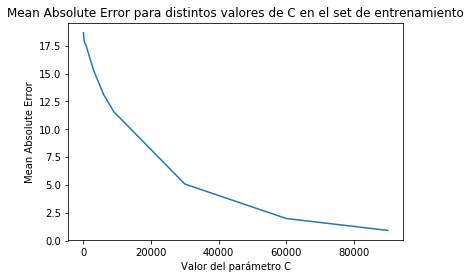

In [91]:
plt.figure()
plt.plot(esp, errores)
plt.title('Mean Absolute Error para distintos valores de C en el set de entrenamiento')
plt.xlabel('Valor del parámetro C')
plt.ylabel('Mean Absolute Error')

El valor que minimiza el error en el set de validación es C = 90000


Text(0,0.5,'Mean Absolute Error')

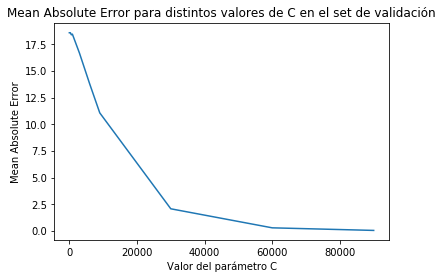

In [92]:
mini, errores = minimoError(BOW_val, etiquetasBOW_val, esp)
print('El valor que minimiza el error en el set de validación es C =', mini)

plt.figure()
plt.plot(esp, errores)
plt.title('Mean Absolute Error para distintos valores de C en el set de validación')
plt.xlabel('Valor del parámetro C')
plt.ylabel('Mean Absolute Error')

In [98]:
espacioC = esp
espacioG = esp
parametros = dict(gamma = espacioG, C = espacioC)
grid = GridSearchCV(SVC(), param_grid = parametros)
grid.fit(BOW_train, etiquetasBOW_train)
print('Los mejores parámetros son %s' %grid.best_params_)

Los mejores parámetros son {'C': 9, 'gamma': 30}


In [103]:
mejorC = list(grid.best_params_.values())[0]
mejorG = list(grid.best_params_.values())[1]
clf = SVC(C = mejorC, gamma = mejorG)
clf.fit(BOW_train, etiquetasBOW_train)

SVC(C=9, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=30, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

MAE para el set de entrenamiento usando RBF:  1.5599239061509194
MAE para el set de validacion usando RBF:  16.483556638246043


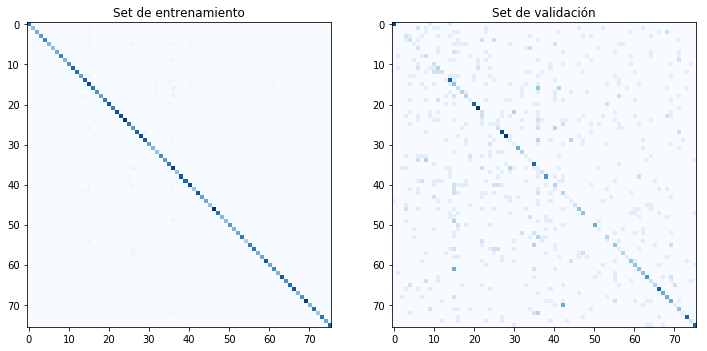

In [122]:
predTrain = []
for i in range(len(BOW_train)):
    predecidasT = clf.predict([BOW_train[i]])
    for j in range(len(predecidasT)):
        predTrain.append(predecidasT[j])
cmT = confusion_matrix(etiquetasBOW_train, predTrain)
print('MAE para el set de entrenamiento usando RBF: ', mean_absolute_error(etiquetasBOW_train, predTrain))
predVal = []
for i in range(len(BOW_val)):
    predecidasV = clf.predict([BOW_val[i]])
    for j in range(len(predecidasT)):
        predVal.append(predecidasV[j])
cmV = confusion_matrix(etiquetasBOW_val, predVal)
print('MAE para el set de validacion usando RBF: ', mean_absolute_error(etiquetasBOW_val, predVal))
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.imshow(cmT, cmap=plt.cm.Blues)
plt.title('Set de entrenamiento')
plt.subplot(1,2,2)
plt.imshow(cmV, cmap=plt.cm.Blues)
plt.title('Set de validación')
plt.show()

In [133]:
def diecinueve(palabras):
    kmeans = KMeans(n_clusters = palabras, random_state = 0).fit(SIFT_train)
    BOW_train = np.zeros((len(imgTrain), palabras))
    etiquetasBOW_train = []
    for i in range(len(imgTrain)):
        representacion = get_bow(imgTrain[i])
        etiquetasBOW_train.append(etiquetasTrain[i])
        print(np.shape(representacion))
        BOW_train[i,:] = representacion
    BOW_val = np.zeros((len(imgVal), palabras))
    etiquetasBOW_val = []
    for i in range(len(imgVal)):
        representacion = get_bow(imgVal[i])
        etiquetasBOW_val.append(etiquetasVal[i])
        BOW_val[i,:] = representacion 
    clf = SVC(C = 9, gamma = 30) # Use los valores del punto 17 porque requiere de mucho computo calcular unos nuevos
    clf.fit(BOW_train, etiquetasBOW_train)
    predTrain = []
    for i in range(len(BOW_train)):
        predecidasT = clf.predict([BOW_train[i]])
        for j in range(len(predecidasT)):
            predTrain.append(predecidasT[j])
    cmT = confusion_matrix(etiquetasBOW_train, predTrain)
    print('MAE para el set de entrenamiento usando RBF: ', mean_absolute_error(etiquetasBOW_train, predTrain))
    predVal = []
    for i in range(len(BOW_val)):
        predecidasV = clf.predict([BOW_val[i]])
        for j in range(len(predecidasT)):
            predVal.append(predecidasV[j])
    cmV = confusion_matrix(etiquetasBOW_val, predVal)
    print('MAE para el set de validacion usando RBF: ', mean_absolute_error(etiquetasBOW_val, predVal))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cmT, cmap = plt.cm.Blues)
    plt.title('Set de entrenamiento')
    plt.subplot(1, 2, 2)
    plt.imshow(cmV, cmap = plt.cm.Blues)
    plt.title('Set de validación')
    plt.show()    

Por un lado, podemos decir que el clasificador con kernel Gaussiano es mucho mejor que el clasificador lineal. El error medio absoluto (MAE), tanto para el set de entrenamiento como para el set de validación resultaron ser menores. Además, como se puede observar en la matriz de confusión la diagonal está bien definida y resaltan los colores azules que son muestra de que las clases fueron asignadas de manera correcta de acuerdo con sus etiquetas reales. 

Por otro lado, el clasificador lineal es mucho más rápido en tiempo de ejecución. La reducción del parámetro C fue más rápida que la sintonización de los parámetros C y gamma que utiliza el clasificador con kernel Gaussiano.